In [2]:
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

CATEGORIES = ['Electron','Muon','Tau','Quark']

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pickle_in = open("XLEP.pickle","rb")
X0 = pickle.load(pickle_in)

pickle_in = open("yLEP.pickle","rb")
z0 = pickle.load(pickle_in)

X = np.array(X0)

y = np.array(z0)

# K-fold cross-validation:

In [3]:


df_x = pd.DataFrame({'X_data': [X[i] for i in range(len(X))] })
df_y = pd.DataFrame({'y_data': y })

df_final = pd.concat([df_y,df_x], axis=1)
df_final.head()


,y_data,X_data
0,0,"[1.1436767578125, 0.9298052191734314, 0.929267..."
1,1,"[1.4359283447265625, 0.28194916248321533, 0.29..."
2,3,"[2.599151611328125, 0.5472841858863831, 0.5643..."
3,1,"[0.9006805419921875, -0.7204799652099609, -0.7..."
4,2,"[1.2020416259765625, -0.5682700872421265, -0.5..."


# training K-times with shufled data and savind the predictions of each time

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential  # for a sequential model 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler

K=10
dense_layer = 1
layer_size = 128
drop_layer = 0.1

pred_cross = {}
score = []
#'fst-LEP-0.1-dr-128-l-1-de.model'
scaler = StandardScaler()

for i in range(K):
    df_final = df_final.sample(frac=1).reset_index(drop=True)  #shuffle the rows only
    X_u = df_final['X_data']
    y_u = df_final['y_data']
    X_test = np.array([X_u[j] for j in range((len(X)//(K)))])
    X_train = np.array([X_u[j] for j in range((len(X)//(K)),len(X))])

    y_test = np.array([y_u[j] for j in range((len(y)//(K)))])
    y_train = np.array([y_u[j] for j in range((len(y)//(K)),len(y))])
    # Fit only to the training data
    scaler.fit(X_train)

    # Now apply the transformations to the data:
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

#    
    NAMEk = "{}-fold-{}-dr-{}-l-{}-de-{}".format(K,drop_layer, layer_size, dense_layer, int(time.time()))
    tensorboard = TensorBoard(log_dir = 'log/{}'.format(NAMEk))

    model = Sequential()
    model.add(Dense(layer_size,input_shape = (int(14),)))
    model.add(Activation('relu'))
    model.add(Dropout(drop_layer))                                       # dropout 10% of the neurons
    #           model.add(MaxPooling2D(pool_size=(2, 2)))

    #           model.add(Flatten())
    for l in range(dense_layer):
        model.add(Dense(layer_size))
        model.add(Activation('relu'))
        model.add(Dropout(drop_layer))# dropout 10% of the neurons

    model.add(Dense(4))
    model.add(Activation('softmax'))

    #tensorboard = TensorBoard(log_dir = 'log/{}'.format(NAME_final))

    #qual otimizador?
    model.compile(loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])

    LEP_model = model.fit(X_train, y_train,
              batch_size=32,
              epochs=10,
              validation_split=0.3,
              callbacks=[tensorboard])

    pred_cross[str(i)+'pred'] = model.predict(X_test)
    score.append(model.evaluate(X_test,y_test))
    

Train on 251999 samples, validate on 108001 samples
Epoch 1/10
251999/251999 [==============================] - 16s 64us/step - loss: 0.0878 - acc: 0.9687 - val_loss: 0.0515 - val_acc: 0.9809
Epoch 2/10
251999/251999 [==============================] - 16s 63us/step - loss: 0.0516 - acc: 0.9811 - val_loss: 0.0446 - val_acc: 0.9817
Epoch 3/10
251999/251999 [==============================] - 16s 63us/step - loss: 0.0455 - acc: 0.9829 - val_loss: 0.0435 - val_acc: 0.9841
Epoch 4/10
251999/251999 [==============================] - 16s 63us/step - loss: 0.0431 - acc: 0.9838 - val_loss: 0.0397 - val_acc: 0.9851
Epoch 5/10
251999/251999 [==============================] - 16s 63us/step - loss: 0.0416 - acc: 0.9844 - val_loss: 0.0410 - val_acc: 0.9837
Epoch 6/10
251999/251999 [==============================] - 16s 63us/step - loss: 0.0407 - acc: 0.9848 - val_loss: 0.0372 - val_acc: 0.9861
Epoch 7/10
251999/251999 [==============================] - 16s 62us/step - loss: 0.0398 - acc: 0.9852 - val

In [645]:
loss = [score[i][0] for i in range(K)]
acc = [score[i][1] for i in range(K)]

print('acc for K={}: {}+-{}'.format(K,np.average(acc),np.std(acc)))

acc for K=10: 0.9866800000000001+-0.0007355100271240353


In [646]:
for i in range(K):
    pred_cross[i] = pd.DataFrame(pred_cross[str(i)+'pred'])
#pred_cross1 = pd.DataFrame(pred_cross['1pred'])
#pred_cross2 = pd.DataFrame(pred_cross['2pred'])
#pred_cross3 = pd.DataFrame(pred_cross['3pred'])
#pred_cross4 = pd.DataFrame(pred_cross['4pred'])
pred_cross['0pred']

array([[0.0000000e+00, 0.0000000e+00, 8.0746402e-18, 1.0000000e+00],
       [1.6610199e-08, 9.8910505e-01, 1.0894936e-02, 2.2300015e-09],
       [4.8509969e-07, 7.5353014e-01, 2.4646670e-01, 2.6560656e-06],
       ...,
       [2.1255244e-09, 9.9924743e-01, 7.5265008e-04, 1.9098740e-09],
       [3.1215457e-15, 9.9994254e-01, 5.7482459e-05, 1.2886323e-12],
       [1.8595629e-24, 2.3349529e-23, 1.3258132e-08, 1.0000000e+00]],
      dtype=float32)

In [47]:
y_pred = []
y_prob=[]
for i in range(K):
    y_pred.append([np.argmax(pred_cross[str(i)+'pred'][j]) for j in range(len(y_test))]) #  10 x 40000 array
    y_prob.append([np.max(pred_cross[str(i)+'pred'][j]) for j in range(len(y_test))])    # 10 x 40000  array

#y_pred_1 = [np.argmax(pred_cross['1pred'][j]) for j in range(len(y_test))]
#y_pred_2 = [np.argmax(pred_cross['2pred'][j]) for j in range(len(y_test))]
#y_pred_3 = [np.argmax(pred_cross['3pred'][j]) for j in range(len(y_test))]
#y_pred_4 = [np.argmax(pred_cross['4pred'][j]) for j in range(len(y_test))]



#y_prob_0 = [np.max(pred_cross['0pred'][j]) for j in range(len(y_test))]
#y_prob_1 = [np.max(pred_cross['1pred'][j]) for j in range(len(y_test))]
#y_prob_2 = [np.max(pred_cross['2pred'][j]) for j in range(len(y_test))]
#y_prob_3 = [np.max(pred_cross['3pred'][j]) for j in range(len(y_test))]
#y_prob_4 = [np.max(pred_cross['4pred'][j]) for j in range(len(y_test))]



In [67]:
y_prob[9][39999]

0.9995627

In [616]:
pd_y_test = pd.DataFrame({'y_test':y_test})
pd_y_prob = {}
pd_y_pred = {}
for i in range(K):
    pd_y_prob['y_prob'+str(i)] = y_prob[i]
    pd_y_pred['y_pred'+str(i)] = y_pred[i]
    
pd_y_prob = pd.DataFrame(pd_y_prob)
pd_y_pred = pd.DataFrame(pd_y_pred)

df_final = pd.concat([pd_y_test,pd_y_pred,pd_y_prob], axis=1)


# Saving the DATA :

In [647]:
#saving df_final

import pickle

pickle_out = open("K-fold-data-LEP.pickle","wb")
pickle.dump(df_final, pickle_out)
pickle_out.close()

In [3]:
#load

pickle_in = open("K-fold-data-LEP.pickle","rb")
df_f= pickle.load(pickle_in)
df_f.head()

,y_test,y_pred0,y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6,y_pred7,y_pred8,...,y_prob0,y_prob1,y_prob2,y_prob3,y_prob4,y_prob5,y_prob6,y_prob7,y_prob8,y_prob9
0,2,3,1,3,3,3,1,3,0,2,...,1.000000,0.999900,1.000000,0.860830,0.999988,0.999978,1.000000,0.999959,0.999861,0.999983
1,0,1,3,3,0,2,1,1,1,2,...,0.989105,1.000000,0.925700,0.999999,0.999943,0.999970,0.999891,0.997840,0.993454,1.000000
2,3,1,2,0,0,2,0,3,0,2,...,0.753530,0.999918,0.997275,0.999379,0.999892,1.000000,1.000000,0.999845,0.998638,0.999959
3,0,3,3,1,2,0,2,0,3,2,...,1.000000,0.997814,0.999503,0.871085,1.000000,0.999933,0.999999,1.000000,0.523190,1.000000
4,0,0,2,3,0,3,3,3,2,2,...,1.000000,0.998810,1.000000,0.999995,1.000000,1.000000,0.999990,0.999959,0.999403,1.000000


In [18]:
K =10
pd_y_test =pd.DataFrame( {'y_test':df_f['y_test']})
y_pred = [df_f['y_pred'+str(i)] for i in range(K)]
y_prob = [df_f['y_prob'+str(i)] for i in range(K)]

## lets do first for the pred0 prob0

In [19]:


df_final00 = pd.concat([pd_y_test,pd.DataFrame({'y_pred0':y_pred[0]}),pd.DataFrame({'y_prob0':y_prob[0]})], axis=1)
df_final00.head() #40000 test events


,y_test,y_pred0,y_prob0
0,2,3,1.000000
1,0,1,0.989105
2,3,1,0.753530
3,0,3,1.000000
4,0,0,1.000000


In [75]:
TP_final = []
FN_final = []
FP_final = []
TN_final = []

sh = 100
sh0 = 0.9999

threshold = [sh0 + (1-sh0)* i/(sh) for i in range(sh)]
#print('threshold:',threshold)

for th in threshold:
    TP = []
    FN = []
    TN = []
    FP = []
    ct=0
    ct1=0
    ct2=0
    ct3=0
    ct4=0
    ct5=0
# true positive : A wolf appear and I see the wolf
    for i in range(len(CATEGORIES)):
        ct = df_final00[(df_final00.y_test ==i) & (df_final00.y_pred0 == i) & (df_final00.y_prob0 > th) ].count()
        TP.append(ct.y_test)
    TP_final.append(TP)
# false negative: A wolf appear but I not see the wolf
    for i in range(len(CATEGORIES)):
        ct1 =df_final00[(df_final00.y_test ==i) & (df_final00.y_pred0 != i) & (df_final00.y_prob0 >th) ].count()
        ct2= df_final00[(df_final00.y_test ==i) & (df_final00.y_pred0 == i) & (df_final00.y_prob0 <th) ].count()
        FN.append(ct1.y_test + ct2.y_test)
    FN_final.append(FN)
# false positive: doesn't have a wolf but I see it 
    for i in range(len(CATEGORIES)):
        ct3 =df_final00[(df_final00.y_test != i) & (df_final00.y_pred0 == i) & (df_final00.y_prob0 > th) ].count()
        FP.append(ct3.y_test)
    FP_final.append(FP)
# true negative: doesn't have a wolf and I do not see it    
    for i in range(len(CATEGORIES)):
        ct4=df_final00[(df_final00.y_test != i) & (df_final00.y_pred0 != i)  & (df_final00.y_prob0 > th)].count()
        ct5 =df_final00[(df_final00.y_test !=i) & (df_final00.y_pred0 == i) & (df_final00.y_prob0 <th) ].count()
        TN.append(ct4.y_test+ct5.y_test)
    TN_final.append(TN)
    

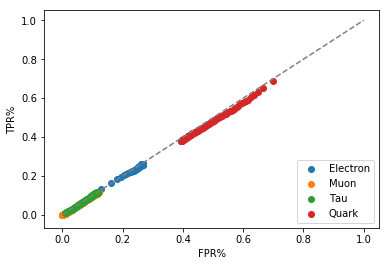

In [76]:
x_lin = np.linspace(0.0, 1.0, sh)
y0 =[[TP_final[i][j]/(TP_final[i][j]+FN_final[i][j]) for i in range(sh)]for j in range(len(CATEGORIES))]
x0 = [[FP_final[i][j]/(FP_final[i][j]+ TN_final[i][j]) for i in range(sh)]for j in range(len(CATEGORIES))]

fig, ax = plt.subplots()
ax.plot(x_lin, x_lin , '--',color = 'gray',)
for j in range(len(CATEGORIES)):
    plt.scatter(x0[j],y0[j],label= CATEGORIES[j])
    plt.legend(loc='lower right',fontsize=10)
plt.xlabel('FPR%')
plt.ylabel('TPR%')

In [77]:
## lets do for the pred1 prob1

df_final11 = pd.concat([pd_y_test,pd.DataFrame({'y_pred1':y_pred[1]}),pd.DataFrame({'y_prob1':y_prob[1]})], axis=1)
df_final11.head() #40000 test events


,y_test,y_pred1,y_prob1
0,2,1,0.999900
1,0,3,1.000000
2,3,2,0.999918
3,0,3,0.997814
4,0,2,0.998810


In [78]:
TP_final = []
FN_final = []
FP_final = []
TN_final = []

#sh = 40
#sh0 = 0.999

threshold = [sh0 + (1-sh0)* i/(sh) for i in range(sh)]
#print('threshold:',threshold)

for th in threshold:
    TP = []
    FN = []
    TN = []
    FP = []
    ct=0
    ct1=0
    ct2=0
    ct3=0
    ct4=0
    ct5=0
# true positive : A wolf appear and I see the wolf
    for i in range(len(CATEGORIES)):
        ct = df_final11[(df_final11.y_test ==i) & (df_final11.y_pred1 == i) & (df_final11.y_prob1 > th) ].count()
        TP.append(ct.y_test)
    TP_final.append(TP)
# false negative: A wolf appear but I not see the wolf
    for i in range(len(CATEGORIES)):
        ct1 =df_final11[(df_final11.y_test ==i) & (df_final11.y_pred1 != i) & (df_final11.y_prob1 >th) ].count()
        ct2= df_final11[(df_final11.y_test ==i) & (df_final11.y_pred1 == i) & (df_final11.y_prob1 <th) ].count()
        FN.append(ct1.y_test + ct2.y_test)
    FN_final.append(FN)
# false positive: doesn't have a wolf but I see it 
    for i in range(len(CATEGORIES)):
        ct3 =df_final11[(df_final11.y_test != i) & (df_final11.y_pred1 == i) & (df_final11.y_prob1 > th) ].count()
        FP.append(ct3.y_test)
    FP_final.append(FP)
# true negative: doesn't have a wolf and I do not see it    
    for i in range(len(CATEGORIES)):
        ct4=df_final11[(df_final11.y_test != i) & (df_final11.y_pred1 != i)  & (df_final11.y_prob1 > th)].count()
        ct5 =df_final11[(df_final11.y_test !=i) & (df_final11.y_pred1 == i) & (df_final11.y_prob1 <th) ].count()
        TN.append(ct4.y_test+ct5.y_test)
    TN_final.append(TN)
    

#x_lin = np.linspace(0.0, 1.0, sh)
y1 =[[TP_final[i][j]/(TP_final[i][j]+FN_final[i][j]) for i in range(sh)]for j in range(len(CATEGORIES))]
x1 = [[FP_final[i][j]/(FP_final[i][j]+ TN_final[i][j]) for i in range(sh)]for j in range(len(CATEGORIES))]

#fig, ax = plt.subplots()
#ax.plot(x_lin, x_lin , '--',color = 'gray',)
#for j in range(len(CATEGORIES)):
#    plt.scatter(x1[j],y1[j],label= CATEGORIES[j])
#    plt.legend(loc='lower right',fontsize=10)
#plt.xlabel('FPR%')
#plt.ylabel('TPR%')

In [79]:
## lets do for the pred2 prob2

df_final22 = pd.concat([pd_y_test,pd.DataFrame({'y_pred2':y_pred[2]}),pd.DataFrame({'y_prob2':y_prob[2]})], axis=1)
df_final22.head() #40000 test events

,y_test,y_pred2,y_prob2
0,2,3,1.000000
1,0,3,0.925700
2,3,0,0.997275
3,0,1,0.999503
4,0,3,1.000000


In [80]:
TP_final = []
FN_final = []
FP_final = []
TN_final = []

#sh = 40
#sh0 = 0.999

threshold = [sh0 + (1-sh0)* i/(sh) for i in range(sh)]
#print('threshold:',threshold)

for th in threshold:
    TP = []
    FN = []
    TN = []
    FP = []
    ct=0
    ct1=0
    ct2=0
    ct3=0
    ct4=0
    ct5=0
# true positive : A wolf appear and I see the wolf
    for i in range(len(CATEGORIES)):
        ct = df_final22[(df_final22.y_test ==i) & (df_final22.y_pred2 == i) & (df_final22.y_prob2 > th) ].count()
        TP.append(ct.y_test)
    TP_final.append(TP)
# false negative: A wolf appear but I not see the wolf
    for i in range(len(CATEGORIES)):
        ct1 =df_final22[(df_final22.y_test ==i) & (df_final22.y_pred2 != i) & (df_final22.y_prob2 >th) ].count()
        ct2= df_final22[(df_final22.y_test ==i) & (df_final22.y_pred2 == i) & (df_final22.y_prob2 <th) ].count()
        FN.append(ct1.y_test + ct2.y_test)
    FN_final.append(FN)
# false positive: doesn't have a wolf but I see it 
    for i in range(len(CATEGORIES)):
        ct3 =df_final22[(df_final22.y_test != i) & (df_final22.y_pred2 == i) & (df_final22.y_prob2 > th) ].count()
        FP.append(ct3.y_test)
    FP_final.append(FP)
# true negative: doesn't have a wolf and I do not see it    
    for i in range(len(CATEGORIES)):
        ct4=df_final22[(df_final22.y_test != i) & (df_final22.y_pred2 != i)  & (df_final22.y_prob2 > th)].count()
        ct5 =df_final22[(df_final22.y_test !=i) & (df_final22.y_pred2 == i) & (df_final22.y_prob2 <th) ].count()
        TN.append(ct4.y_test+ct5.y_test)
    TN_final.append(TN)
    

x_lin = np.linspace(0.0, 1.0, sh)
y2 =[[TP_final[i][j]/(TP_final[i][j]+FN_final[i][j]) for i in range(sh)]for j in range(len(CATEGORIES))]
x2 = [[FP_final[i][j]/(FP_final[i][j]+ TN_final[i][j]) for i in range(sh)]for j in range(len(CATEGORIES))]

#fig, ax = plt.subplots()
#ax.plot(x_lin, x_lin , '--',color = 'gray',)
#for j in range(len(CATEGORIES)):
#    plt.scatter(x2[j],y2[j],label= CATEGORIES[j])
#    plt.legend(loc='lower right',fontsize=10)
#plt.xlabel('FPR%')
#plt.ylabel('TPR%')

In [81]:
## lets do for the pred2 prob2

df_final33 = pd.concat([pd_y_test,pd.DataFrame({'y_pred3':y_pred[3]}),pd.DataFrame({'y_prob3':y_prob[3]})], axis=1)
df_final33.head() #40000 test events

,y_test,y_pred3,y_prob3
0,2,3,0.860830
1,0,0,0.999999
2,3,0,0.999379
3,0,2,0.871085
4,0,0,0.999995


In [82]:
TP_final = []
FN_final = []
FP_final = []
TN_final = []

#sh = 40
#sh0 = 0.999

threshold = [sh0 + (1-sh0)* i/(sh) for i in range(sh)]
#print('threshold:',threshold)

for th in threshold:
    TP = []
    FN = []
    TN = []
    FP = []
    ct=0
    ct1=0
    ct2=0
    ct3=0
    ct4=0
    ct5=0
# true positive : A wolf appear and I see the wolf
    for i in range(len(CATEGORIES)):
        ct = df_final33[(df_final33.y_test ==i) & (df_final33.y_pred3 == i) & (df_final33.y_prob3 > th) ].count()
        TP.append(ct.y_test)
    TP_final.append(TP)
# false negative: A wolf appear but I not see the wolf
    for i in range(len(CATEGORIES)):
        ct1 =df_final33[(df_final33.y_test ==i) & (df_final33.y_pred3 != i) & (df_final33.y_prob3 >th) ].count()
        ct2= df_final33[(df_final33.y_test ==i) & (df_final33.y_pred3 == i) & (df_final33.y_prob3 <th) ].count()
        FN.append(ct1.y_test + ct2.y_test)
    FN_final.append(FN)
# false positive: doesn't have a wolf but I see it 
    for i in range(len(CATEGORIES)):
        ct3 =df_final33[(df_final33.y_test != i) & (df_final33.y_pred3 == i) & (df_final33.y_prob3 > th) ].count()
        FP.append(ct3.y_test)
    FP_final.append(FP)
# true negative: doesn't have a wolf and I do not see it    
    for i in range(len(CATEGORIES)):
        ct4=df_final33[(df_final33.y_test != i) & (df_final33.y_pred3 != i)  & (df_final33.y_prob3 > th)].count()
        ct5 =df_final33[(df_final33.y_test !=i) & (df_final33.y_pred3 == i) & (df_final33.y_prob3 <th) ].count()
        TN.append(ct4.y_test+ct5.y_test)
    TN_final.append(TN)
    

#x_lin = np.linspace(0.0, 1.0, sh)
y3 =[[TP_final[i][j]/(TP_final[i][j]+FN_final[i][j]) for i in range(sh)]for j in range(len(CATEGORIES))]
x3 = [[FP_final[i][j]/(FP_final[i][j]+ TN_final[i][j]) for i in range(sh)]for j in range(len(CATEGORIES))]

#fig, ax = plt.subplots()
#ax.plot(x_lin, x_lin , '--',color = 'gray',)
#for j in range(len(CATEGORIES)):
#    plt.scatter(x3[j],y3[j],label= CATEGORIES[j])
#    plt.legend(loc='lower right',fontsize=10)
#plt.xlabel('FPR%')
#plt.ylabel('TPR%')

In [83]:
# Average

#y[3][39]
y = [y0,y1,y2,y3]
x = [x0,x1,x2,x3]#K=4 x CAT=4 X SH=40
TPR_ave = []
FPR_ave = []

for j in range(len(CATEGORIES)):
    ttt = []
    qqq =[]
    for k in range(sh):
        ttt.append(np.average([y[i][j][k] for i in range(3)]))
        qqq.append(np.average([x[i][j][k] for i in range(3)]))
    TPR_ave.append(ttt)
    FPR_ave.append(qqq)
print(len(TPR_ave),len(FPR_ave))



# Standard deviation

TPR_std = []
FPR_std = []

for j in range(len(CATEGORIES)):
    ttt = []
    qqq =[]
    for k in range(sh):
        ttt.append(np.std([y[i][j][k] for i in range(3)]))
        qqq.append(np.std([x[i][j][k] for i in range(3)]))
    TPR_std.append(ttt)
    FPR_std.append(qqq)
print(len(TPR_std),len(FPR_std))

4 4
4 4


c:\programdata\anaconda3\lib\site-packages\matplotlib\pyplot.py:2922: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


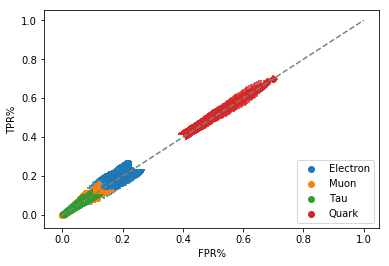

In [84]:
fig, ax = plt.subplots()
ax.plot(x_lin, x_lin , '--',color = 'gray',)
for j in range(len(CATEGORIES)):
    plt.scatter(TPR_ave[j],FPR_ave[j],label= CATEGORIES[j])
    plt.errorbar(TPR_ave[j],FPR_ave[j], yerr=TPR_std[j], xerr=FPR_std[j], hold=True, fmt='none')
    plt.legend(loc='lower right',fontsize=10)
plt.xlabel('FPR%')
plt.ylabel('TPR%')